# Example 1-C: Ghost

This example computes the $H^1$ and $L^2$ (semi-)inner products of two 
functions, $v,w$ with the property that they are the sum of a harmonic 
function and a polynomial.

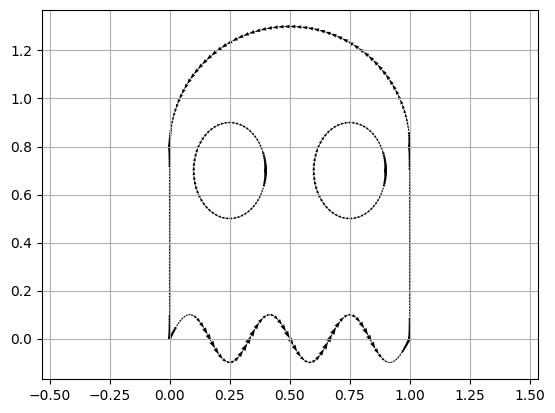

Setting up Nyström solver... 768 sampled points on 6 edges


In [1]:
import sys
import os

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
sys.path.append(parent_dir)

import puncturedfem as pf
import numpy as np
import matplotlib.pyplot as plt

# define quadrature schemes
n = 64
q_trap = pf.quad(qtype='trap', n=n)
q_kress = pf.quad(qtype='kress', n=n)
quad_dict = {'kress': q_kress, 'trap': q_trap}

# define vertices
verts = []
verts.append(pf.vert(x=0.0, y=0.0)) # 0
verts.append(pf.vert(x=1.0, y=0.0)) # 1
verts.append(pf.vert(x=1.0, y=0.8)) # 2
verts.append(pf.vert(x=0.0, y=0.8)) # 3
verts.append(pf.vert(x=0.25, y=0.7)) # 4
verts.append(pf.vert(x=0.75, y=0.7)) # 5

# define edges
edges = []
edges.append(pf.edge(verts[0], verts[1], pos_cell_idx=0,
      curve_type='sine_wave', amp=0.1, freq=6))
edges.append(pf.edge(verts[1], verts[2], pos_cell_idx=0))
edges.append(pf.edge(verts[2], verts[3], pos_cell_idx=0,
      curve_type='circular_arc_deg', theta0=180))
edges.append(pf.edge(verts[3], verts[0], pos_cell_idx=0))
edges.append(pf.edge(verts[4], verts[4], neg_cell_idx=0,
	  curve_type='ellipse', a=0.15, b=0.2))
edges.append(pf.edge(verts[5], verts[5], neg_cell_idx=0,
	  curve_type='ellipse', a=0.15, b=0.2))

# define mesh cell
K = pf.cell(id=0, edges=edges)

# parameterize edges
K.parameterize(quad_dict)

# plot boundary
pf.plot_edges(edges, orientation=True)

# set up Nyström solver
solver = pf.nystrom_solver(K, verbose=True)

## Define local functions
Consider the functions
\begin{align*}
	v(x) &= \frac{x_1 - 0.25}{(x_1 - 0.25)^2 + (x_2 - 0.7)^2}
	+ x_1^3 x_2 + x_2^2
	~,
	\\[12pt]
	w(x) &= \ln\big[(x_1 - 0.75)^2 + (x_2 - 0.7)^2\big] 
	+ x_1^2 x_2^2 - x_1 x_2^3
	~.
\end{align*}
It holds that 
\begin{align*}
	\Delta v(x) &= 6 x_1 x_2 +2
	~,
	\\[12pt]
	\Delta w(x) &= 2 x_1^2 - 6 x_1 x_2 + 2 x_2^2
	~.
\end{align*}

In [2]:
# get coordinates of boundary points
x1, x2 = K.get_boundary_points()

################################################################################

# trace of v
v_trace = (x1 - 0.25) / ((x1 - 0.25) ** 2 + (x2 - 0.7) ** 2) + \
   (x1 ** 3) * x2 + x2 ** 2

# Laplacian of v
v_laplacian = pf.polynomial([
   [6.0, 1, 1],
   [2.0, 0, 0]
])

# store v as a local function object
v = pf.locfun(solver=solver, lap_poly=v_laplacian, has_poly_trace=False)
v.set_trace_values(v_trace)

################################################################################

# trace of w
w_trace = np.log((x1 - 0.75) ** 2 + (x2 - 0.7) ** 2) + \
   (x1 ** 2) * (x2 ** 2) - x1 * (x2 ** 3)

# Laplacian of w
w_laplacian = pf.polynomial([
   [2.0, 2, 0],
   [-6.0, 1, 1],
   [2.0, 0, 2]
])

# store w as a local function object
w = pf.locfun(solver=solver, lap_poly=w_laplacian, has_poly_trace=False)
w.set_trace_values(w_trace)

# compute quanties needed for integration
v.compute_all()
w.compute_all()

## $H^1$ semi-inner product

Let's compute the $H^1$ semi-inner product 
\begin{align*}
	\int_K \nabla v \cdot \nabla w ~dx
	&\approx
	-6.311053612386
	\pm 3.6161 \times 10^{-12}
\end{align*}
whose approximate value was obtained with *Mathematica*. 

In [3]:
h1_vw_computed = v.get_h1_semi_inner_prod(w)
print('Computed H^1 semi-inner product = ', h1_vw_computed)

h1_vw_exact = -6.311053612386
h1_vw_error = abs(h1_vw_computed - h1_vw_exact)
print('Error in H^1 semi-inner product = %.4e'%(h1_vw_error))

Computed H^1 semi-inner product =  -6.311053612366302
Error in H^1 semi-inner product = 1.9698e-11


Let's do the same for the $L^2$ inner product
\begin{align*}
	\int_K v \, w ~dx
	&\approx -3.277578636852
	\pm 1.0856\times 10^{-13}
\end{align*}

In [4]:
l2_vw_computed = v.get_l2_inner_prod(w)
print('Computed L^2 inner product = ', l2_vw_computed)

l2_vw_exact = -3.277578636852
l2_vw_error = abs(l2_vw_computed - l2_vw_exact)
print('Error in L^2 inner product = %.4e'%l2_vw_error)

Computed L^2 inner product =  -3.2775786368058046
Error in L^2 inner product = 4.6195e-11


## Convergence Study

|	n	|	H1 error	|	L2 error	|
|-------|---------------|---------------|
|	4	|	2.4336e+00	|	5.9408e-03	|
|	8	|	1.0269e-02	|	1.3086e-02	|
|	16	|	1.5273e-03	|	1.3783e-04	|
|	32	|	5.3219e-07	|	8.1747e-07	|
|	64	|	1.5430e-11	|	4.6189e-11	|

In [5]:
print('H^1 error (vw) = %.4e'%h1_vw_error)
print('L^2 error (vw) = %.4e'%l2_vw_error)

H^1 error (vw) = 1.9698e-11
L^2 error (vw) = 4.6195e-11


## Interior values

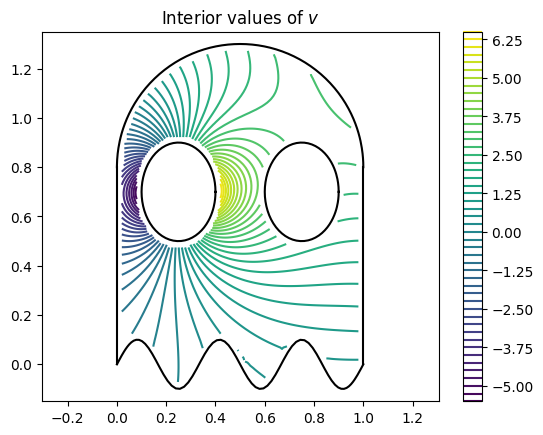

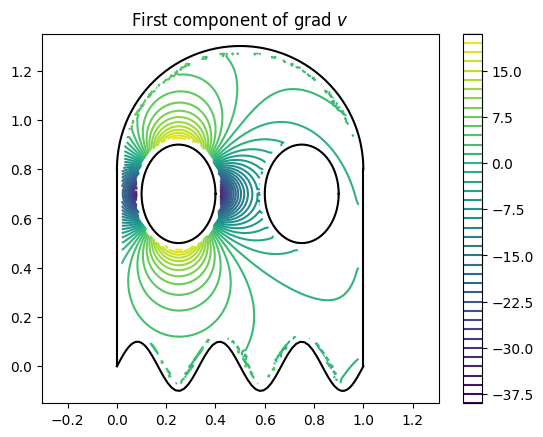

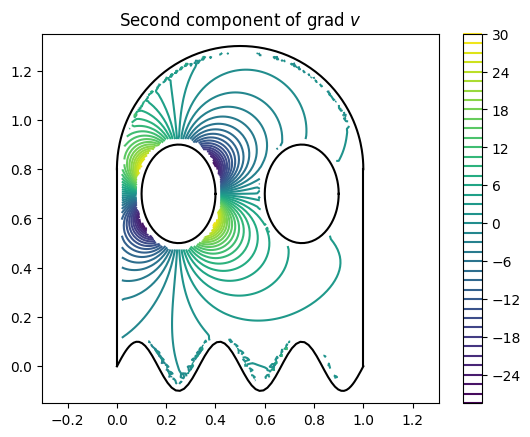

In [6]:
y1 = K.int_x1
y2 = K.int_x2

v.compute_interior_values()

v_computed = v.int_vals
v_x1_computed = v.int_grad1
v_x2_computed = v.int_grad2

plt.figure()
for e in K.get_edges():
	e_x1, e_x2 = e.get_sampled_points()
	plt.plot(e_x1, e_x2, 'k')
plt.contour(y1, y2, v_computed, levels=50)
plt.colorbar()
plt.title('Interior values of $v$')
plt.axis('equal')
plt.ylim([-0.15, 1.35])

plt.figure()
for e in K.get_edges():
	e_x1, e_x2 = e.get_sampled_points()
	plt.plot(e_x1, e_x2, 'k')
plt.contour(y1, y2, v_x1_computed, levels=50)
plt.colorbar()
plt.title('First component of grad $v$')
plt.axis('equal')
plt.ylim([-0.15, 1.35])

plt.figure()
for e in K.get_edges():
	e_x1, e_x2 = e.get_sampled_points()
	plt.plot(e_x1, e_x2, 'k')
plt.contour(y1, y2, v_x2_computed, levels=50)
plt.colorbar()
plt.title('Second component of grad $v$')
plt.axis('equal')
plt.ylim([-0.15, 1.35])

plt.show()

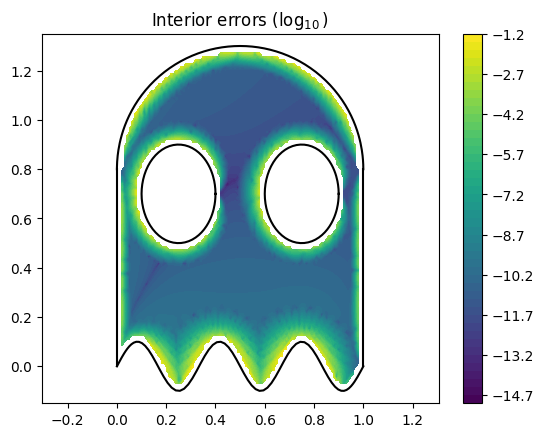

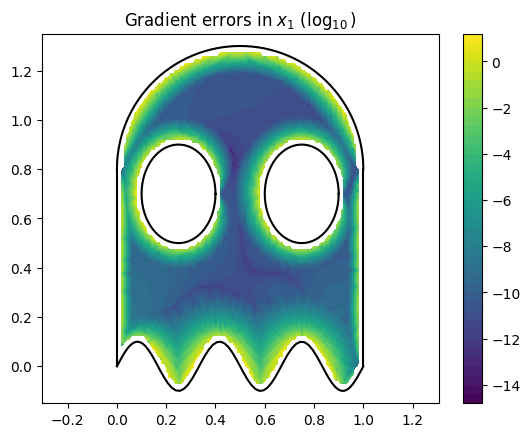

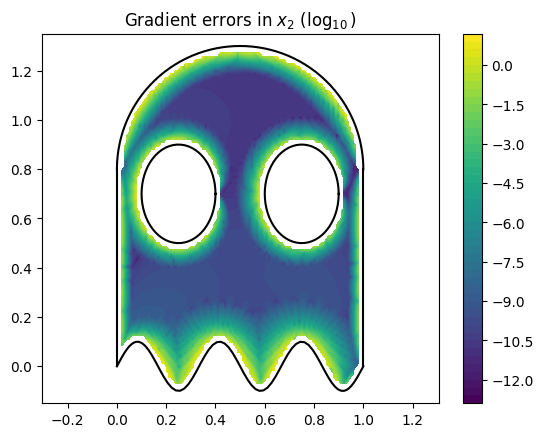

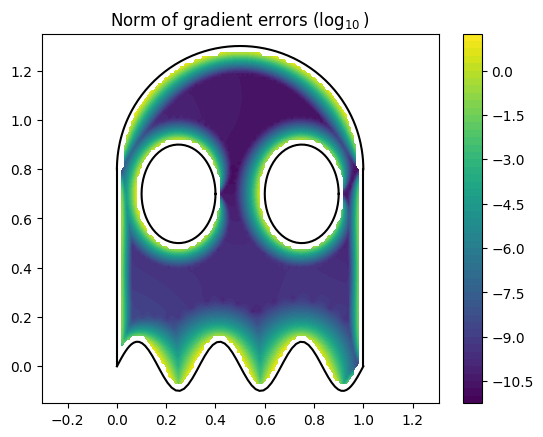

In [7]:
# exact values
v_exact = (y1 - 0.25) / ((y1 - 0.25) ** 2 + (y2 - 0.7) ** 2) + \
   (y1 ** 3) * y2 + y2 ** 2
v_x1_exact = -((y1 - 0.25) ** 2 - (y2 - 0.7) ** 2) / \
    ((y1 - 0.25) ** 2 + (y2 - 0.7) ** 2) ** 2 + \
    3 * (y1 ** 2) * y2
v_x2_exact = -2 * (y1 - 0.25) * (y2 - 0.7) / \
    ((y1 - 0.25) ** 2 + (y2 - 0.7) ** 2) ** 2 + \
    (y1 ** 3) + 2 * y2 

# interior value errors
v_error = np.log10(np.abs(v_computed - v_exact))
plt.figure()
for e in K.get_edges():
	e_x1, e_x2 = e.get_sampled_points()
	plt.plot(e_x1, e_x2, 'k')
plt.contourf(y1, y2, v_error, levels=50)
plt.colorbar()
plt.title('Interior errors ($\log_{10}$)')
plt.axis('equal')
plt.ylim([-0.15, 1.35])

# first component of gradient errors
v_x1_error = np.log10(np.abs(v_x1_computed - v_x1_exact))
plt.figure()
for e in K.get_edges():
	e_x1, e_x2 = e.get_sampled_points()
	plt.plot(e_x1, e_x2, 'k')
plt.contourf(y1, y2, v_x1_error, levels=50)
plt.colorbar()
plt.title('Gradient errors in $x_1$ ($\log_{10}$)')
plt.axis('equal')
plt.ylim([-0.15, 1.35])

# second component of gradient errors
v_x2_error = np.log10(np.abs(v_x2_computed - v_x2_exact))
plt.figure()
for e in K.get_edges():
	e_x1, e_x2 = e.get_sampled_points()
	plt.plot(e_x1, e_x2, 'k')
plt.contourf(y1, y2, v_x2_error, levels=50)
plt.colorbar()
plt.title('Gradient errors in $x_2$ ($\log_{10}$)')
plt.axis('equal')
plt.ylim([-0.15, 1.35])

# norm of gradient errors
v_grad_error = (v_x1_computed - v_x1_exact) ** 2 \
    + (v_x2_computed - v_x2_exact) ** 2
v_grad_error = 0.5 * np.log10(v_grad_error)
plt.figure()
for e in K.get_edges():
	e_x1, e_x2 = e.get_sampled_points()
	plt.plot(e_x1, e_x2, 'k')
plt.contourf(y1, y2, v_grad_error, levels=50)
plt.colorbar()
plt.title('Norm of gradient errors ($\log_{10}$)')
plt.axis('equal')
plt.ylim([-0.15, 1.35])

plt.show()

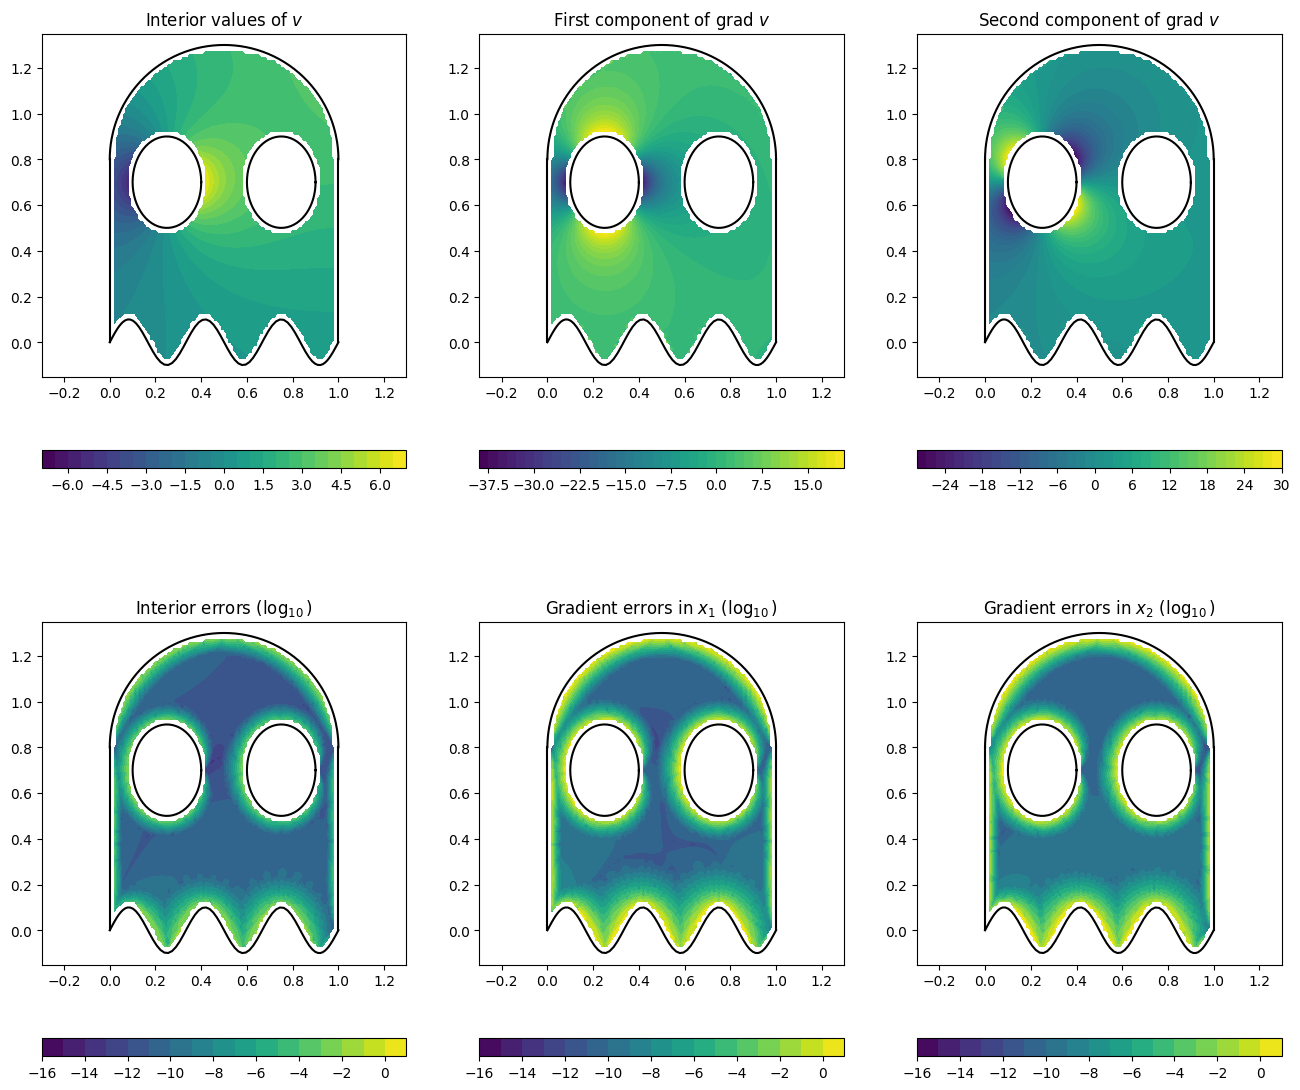

In [8]:
plt.figure(figsize=(16, 14), dpi=100)

plt.subplot(2, 3, 1)
for e in K.get_edges():
	e_x1, e_x2 = e.get_sampled_points()
	plt.plot(e_x1, e_x2, 'k')
plt.contourf(y1, y2, v_computed, levels=np.linspace(-7,7,28+1))
plt.colorbar(location='bottom')
plt.title('Interior values of $v$')
plt.axis('equal')
plt.ylim([-0.15, 1.35])

plt.subplot(2, 3, 2)
for e in K.get_edges():
	e_x1, e_x2 = e.get_sampled_points()
	plt.plot(e_x1, e_x2, 'k')
plt.contourf(y1, y2, v_x1_computed, levels=50)
plt.colorbar(location='bottom')
plt.title('First component of grad $v$')
plt.axis('equal')
plt.ylim([-0.15, 1.35])

plt.subplot(2, 3, 3)
for e in K.get_edges():
	e_x1, e_x2 = e.get_sampled_points()
	plt.plot(e_x1, e_x2, 'k')
plt.contourf(y1, y2, v_x2_computed, levels=50)
plt.colorbar(location='bottom')
plt.title('Second component of grad $v$')
plt.axis('equal')
plt.ylim([-0.15, 1.35])

# interior value errors
plt.subplot(2, 3, 4)
for e in K.get_edges():
	e_x1, e_x2 = e.get_sampled_points()
	plt.plot(e_x1, e_x2, 'k')
plt.contourf(y1, y2, v_error, levels=np.linspace(-16,1,18))
plt.colorbar(location='bottom')
plt.title('Interior errors ($\log_{10}$)')
plt.axis('equal')
plt.ylim([-0.15, 1.35])

# first component of gradient errors
plt.subplot(2, 3, 5)
for e in K.get_edges():
	e_x1, e_x2 = e.get_sampled_points()
	plt.plot(e_x1, e_x2, 'k')
plt.contourf(y1, y2, v_x1_error, levels=np.linspace(-16,1,18))
plt.colorbar(location='bottom')
plt.title('Gradient errors in $x_1$ ($\log_{10}$)')
plt.axis('equal')
plt.ylim([-0.15, 1.35])

# second component of gradient errors
plt.subplot(2, 3, 6)
for e in K.get_edges():
	e_x1, e_x2 = e.get_sampled_points()
	plt.plot(e_x1, e_x2, 'k')
plt.contourf(y1, y2, v_x2_error, levels=np.linspace(-16,1,18))
plt.colorbar(location='bottom')
plt.title('Gradient errors in $x_2$ ($\log_{10}$)')
plt.axis('equal')
plt.ylim([-0.15, 1.35])

# plt.savefig('ghost-fig.pdf', format='pdf', bbox_inches='tight')

plt.show()